# 4. Convolutional Variational Autoencoder
- MNIST dataset
- Variational Inference 
- Convolutional 
- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)

## 1. Settings

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Data

In [31]:
mnist_train = dset.FashionMNIST("./data/FMNIST", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.FashionMNIST("./data/FMNIST", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [32]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

## 3. Model

In [33]:
hidden_size = 100

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 8 x 28 x 28
                        nn.BatchNorm2d(8),
                        nn.ReLU(),
                        nn.MaxPool2d(2,2), 
                        nn.Conv2d(8,16,3,padding=1),  # batch x 16 x 14 x 14
                        nn.BatchNorm2d(16),
                        nn.ReLU(),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(16,32,3,padding=1),  # batch x 32 x 7 x 7
                        nn.ReLU(),
        )
        self.fc2_1 = nn.Sequential(
                        nn.Linear(32*7*7, 800),
                        nn.Linear(800, hidden_size),
        )
        self.fc2_2 = nn.Sequential(
                        nn.Linear(32*7*7, 800),
                        nn.Linear(800, hidden_size),
        )
        self.relu = nn.ReLU()
                        
    def encode(self,x):
        #x = x.view(batch_size,-1)
        out = self.fc1(x)
        out = out.view(batch_size,-1)
        out = self.relu(out)
        mu = self.fc2_1(out)
        log_var = self.fc2_2(out)
        return mu,log_var
    
    def forward(self,x):
        mu, logvar = self.encode(x)
        noise = Variable(torch.randn(mu.size()).cuda())
        z = mu+logvar.exp()*noise    
        
        return z,mu,logvar
        
encoder = Encoder().cuda()

In [36]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1 = nn.Sequential(
                        nn.Linear(hidden_size,800),
                        nn.BatchNorm1d(800),
                        nn.ReLU(),
                        nn.Linear(800,1568),
                        nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
                        nn.ConvTranspose2d(32,16,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,8,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(8),
                        nn.ConvTranspose2d(8,1,3,1,1),
                        nn.BatchNorm2d(1),
        )
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = out.view(batch_size,32,7,7)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(batch_size,1,28,28)
        
        return out
        
decoder = Decoder().cuda()

## 4. Loss func & Optimizer

In [37]:
reconstruction_function = nn.BCELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

parameters = list(encoder.parameters())+ list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0005)

## 5. Train 

In [41]:
try:
    encoder, decoder = torch.load('./model/conv_variational_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

# num_epoch = 20

# for i in range(num_epoch):
#     for j,[image,label] in enumerate(train_loader):
#         optimizer.zero_grad()
        
#         image = Variable(image).cuda()
#         z, mu,log_var  = encoder(image)
#         output = decoder(z)
        
#         loss = loss_function(output, image, mu, log_var)
        
#         loss.backward()
#         optimizer.step()

# #         if j % 10 == 0:
# #             torch.save([encoder,decoder],'./model/conv_variational_autoencoder.pkl')
# #             print(loss)
#     print("loss is", loss.cpu().data.numpy()[0])        



--------model restored--------



## 6. Check with Train Image

torch.Size([128, 28, 28])


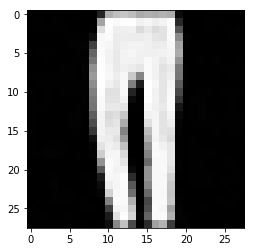

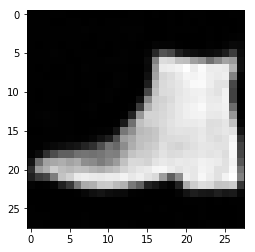

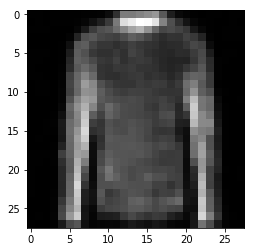

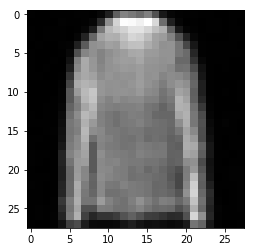

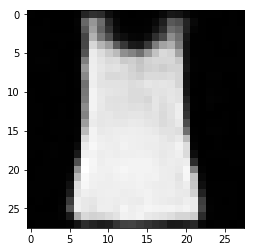

In [39]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    #plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    #plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## 7. Check with Test Image

In [42]:
for i in range(1):
    for j,[image,label] in enumerate(test_loader):
       
        image = Variable(image,volatile=True).cuda()
        output,mean,var = encoder(image)
        output = decoder(output)
        
    if j % 10 == 0:
        print(loss)        

torch.Size([128, 28, 28])


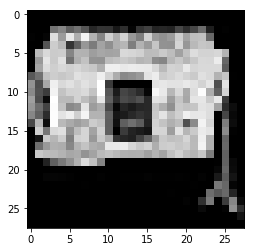

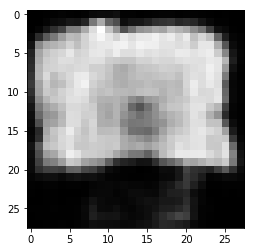

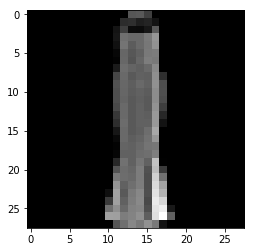

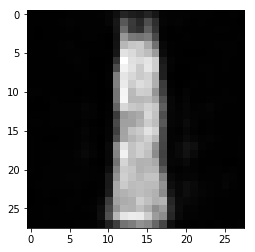

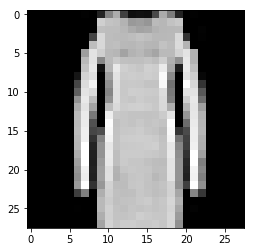

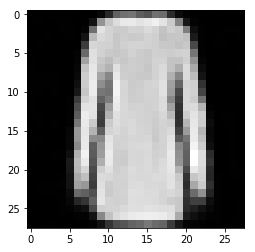

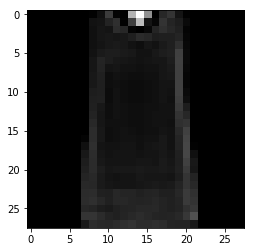

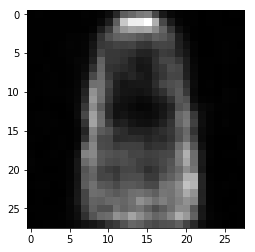

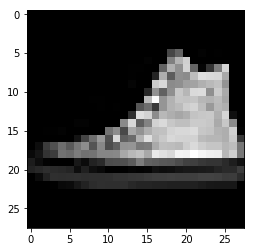

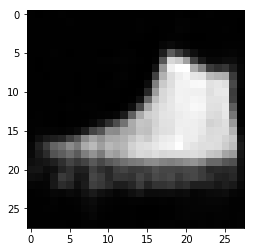

In [43]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(),cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()